In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_diabetes
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
X, y = load_diabetes(return_X_y=True)
X = (X - X.mean(axis=0)) / X.std(axis=0)
y = (y - y.mean()) / y.std()

In [3]:
X.shape

(442, 10)

In [4]:
y.shape

(442,)

## Parametric confidence intervals

In [5]:
ols = sm.OLS(y, sm.add_constant(X))
ols_results = ols.fit()

In [6]:
ols_results.params

array([-1.66967135e-16, -6.18436559e-03, -1.48132204e-01,  3.21096262e-01,
        2.00370492e-01, -4.89318785e-01,  2.94477857e-01,  6.24135255e-02,
        1.09369553e-01,  4.64052556e-01,  4.17710597e-02])

In [7]:
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     46.27
Date:                Tue, 15 Feb 2022   Prob (F-statistic):           3.83e-62
Time:                        00:55:13   Log-Likelihood:                -466.00
No. Observations:                 442   AIC:                             954.0
Df Residuals:                     431   BIC:                             999.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.67e-16      0.033  -4.99e-15      1.0

In [8]:
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
print(f"RMSE by mean: {np.sqrt(np.mean((y-np.mean(y))**2))}")
print(f"train RMSE: {np.sqrt(np.mean((y-y_pred)**2))}")

RMSE by mean: 1.0
train RMSE: 0.694442635922296


In [9]:
model.coef_

array([-0.00618437, -0.1481322 ,  0.32109626,  0.20037049, -0.48931879,
        0.29447786,  0.06241353,  0.10936955,  0.46405256,  0.04177106])

/home/marti/.pyenv/versions/3.8.5/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


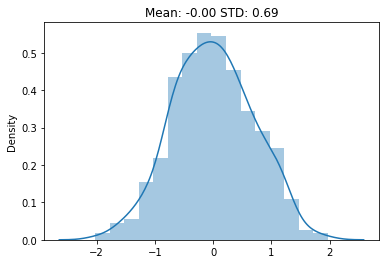

In [10]:
mean = np.mean(y-y_pred)
std = np.std(y-y_pred)
ax = sns.distplot(y-y_pred)
_ = ax.set_title(f"Mean: {mean:0.2f} STD: {std:0.2f}")

## Bootstrapped confidence intervals

In [11]:
def bootstraped_coeffs(X: np.ndarray, y: np.ndarray, boot_samples: int = 1000, seed: int = 1):
    coef_list = list()
    random_state = np.random.RandomState(seed=seed)
    params_model = LinearRegression()
    params_model.fit(X, y)
    y_pred = params_model.predict(X)
    eps = y - y_pred
    for _ in range(boot_samples):
        eps_sampled = random_state.choice(eps, size=len(eps))
        y_samples = eps_sampled + y_pred
        model_for_samples = LinearRegression()
        model_for_samples.fit(X, y_samples)
        coef_list.append(np.hstack((model_for_samples.intercept_, model_for_samples.coef_)))
    return np.vstack(coef_list)

In [12]:
coef_list = bootstraped_coeffs(X, y, boot_samples=1000)

## Bayesian confidence intervals

In [13]:
import pymc3 as pm
from pymc3 import HalfCauchy, Model, Normal, sample
import arviz as az

SIGMA_PRIOR = 10
with Model() as model:
    sigma = HalfCauchy("sigma", beta=SIGMA_PRIOR)
    intercept = Normal("x0", 0, sigma=SIGMA_PRIOR)
    x_coeff = Normal("x", 0, sigma=SIGMA_PRIOR, shape=(X.shape[1]))

    likelihood = Normal("y", mu=intercept + pm.math.dot(X, x_coeff), sigma=sigma, observed=y)

    trace = sample(3000, return_inferencedata=True)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, x0, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 19 seconds.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7164998312786479, but should be close to 0.8. Try to increase the number of tuning steps.


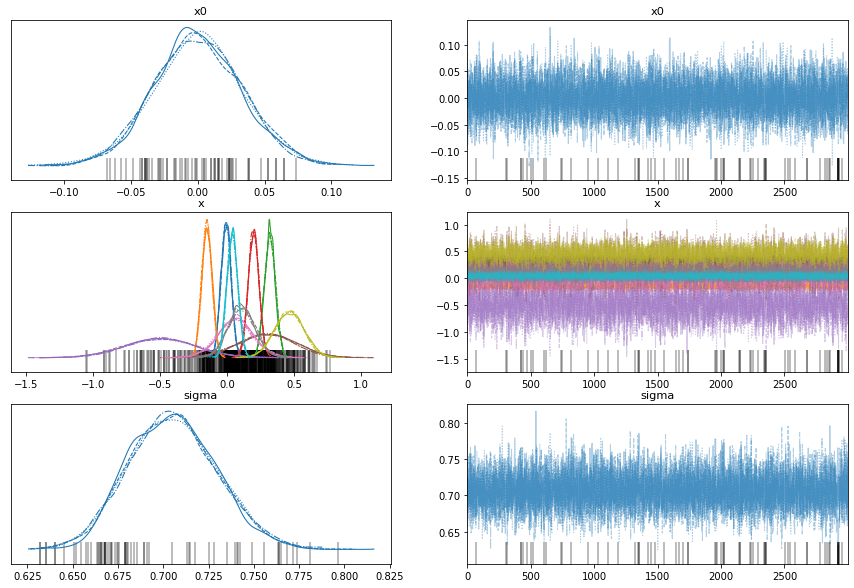

In [14]:
_ = az.plot_trace(trace, figsize=(15, 10))
x_chains = trace.posterior.x.to_numpy()
x_chains = x_chains.reshape((x_chains.shape[1]*x_chains.shape[0], -1))
intercept_chains = trace.posterior.x0.to_numpy()
intercept_chains = intercept_chains.reshape((intercept_chains.shape[1]*intercept_chains.shape[0], -1))
chains = np.hstack((intercept_chains, x_chains))

In [15]:
bootstraped_intervals = np.vstack((np.percentile(coef_list, 2.5, axis=0), np.percentile(coef_list, 97.5, axis=0))).T
ols_conf_int = ols_results.conf_int()
bayes_intervals = np.vstack((np.percentile(chains, 2.5, axis=0), np.percentile(chains, 97.5, axis=0))).T

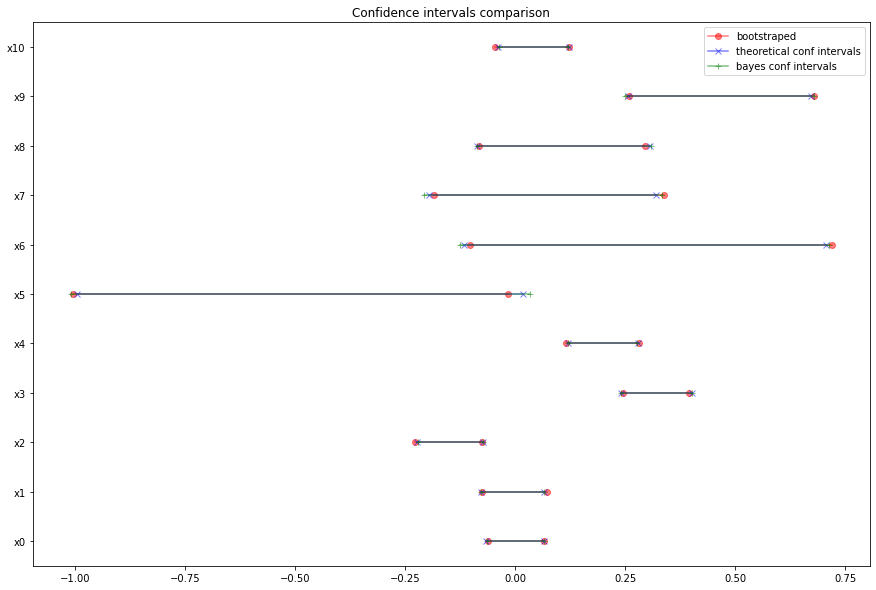

In [16]:
ax, fig = plt.subplots(figsize=(15, 10))
for idx in range(bootstraped_intervals.shape[0]):
    _ = plt.plot((bootstraped_intervals[idx, 0], bootstraped_intervals[idx, 1]),(idx,idx),'o-',color="red", alpha=0.5, label="bootstraped")
    _ = plt.plot((ols_conf_int[idx, 0], ols_conf_int[idx, 1]),(idx,idx),'x-',color="blue", alpha=0.5, label="theoretical conf intervals")
    _ = plt.plot((bayes_intervals[idx, 0], bayes_intervals[idx, 1]),(idx,idx),'+-',color="green", alpha=0.5, label="bayes conf intervals")


_ = plt.yticks(np.arange(bootstraped_intervals.shape[0]), [f"x{i}" for i in range(bootstraped_intervals.shape[0])])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
_ = plt.legend(by_label.values(), by_label.keys())
_ = plt.title("Confidence intervals comparison")